## Data Simulator

In this notebook, we define code to generate simulated growth curves for use in downstream embedding tasks. The basic idea here is to just generate a ton of data for later use in embedding from our ODE model of our system. First we start by importing all critical libraries of interest: 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint, solve_ivp

Next let's actually define our growth model. Of the variable ways to generate these growth models we leverage the 'complex' version which has teh most expressivity in the system. In this system, we model three variables of interest: the cell population density given by $n(t)$, the concentration of beta-lactamase enzyme which degrades beta-lactam antibiotic given by $b(t)$, and lastly the actual concentration of the antibiotic $a(t)$. The three variables couple with each other to generate the resulting dynamics. Additionally, Bla inhibitor can also be optionally introduced into the system. 

Let's break down the dynamics of each variable. First the bacteria undergo growth kinetics given by:

$$
\dfrac{d n}{d t} = (\alpha g  - \beta \ell)
$$

The first term in the parenthesis represents the intrinsic, basal growth rate of the population. $\alpha$ is the maximum basical growth rate, but it is modulated by current population size ($n$) and some shape parameters such as the carrying capacity:

$$
g =  \left( \dfrac{1}{1 + \left( \frac{n}{N_m K_s} \right)^{\theta} } \right) \left( 1 - \dfrac{n}{N_m}\right)
$$


Here $N_m$ is the carrying capacity of the population. $\theta$ and $K_s$ modulat the Hill kinetic shape and are purely phenomonological parameters constructed to ensure the basal growth rate, independent of any antibiotic or inhibitor effects, is sufficently expressive to capture the highly variable growth dynamics of hundreds of different bacterial isolates. 

Next to discuss is the degradation of cells. This is driven primarily by the presense of antibiotic. First let's treat $\beta$ which possesses the functional form:

$$
\beta = \beta_{min} + c \, ( 1- \beta_{min} ) \quad  \text{if} \quad I > 0 
$$

$\beta$ is a measure of the suspectibility of individual cells to antibiotic provided by their **intracellular** Bla enzyme. It is however *inversely* correlated, meaning a higher $\beta_{min}$ indicates that cells are **more** protected from antibiotic, i.e. their intracellular Bla enzymes are effective. Now if an Bla inhibitor such as clavulanic acid is present, $I$, then we need to modulate the intracellular protection against antibiotic depending on how permeable individual cells are to inhibitor, which is in turn given by $c$. $c$ takes on values from $0$ to $1$, where $0$ indicates that the inhibitor cannot enter WITHIN a cell and weaken its intracellular Bla enzymes while $1$ indicates that it is totally permeable, and inhibitor can weaken internal Bla protection, making the cell overall more susceptible to  damage from antibiotic. If there is no inhibitor present then $c = 0$, of course. 

Next to consider is $\ell$ which in turn is measure of the lysis rate and is modulated by $\beta$ as discussed earlier. The lysis rate is naturally tied to the antibiotic concentration and is dictated by the standard MM kinetics:

$$
\ell = \gamma \dfrac{g h_{a}}{1 + a h_{a}}
$$

Where $\gamma$ is the maximal lysis rate and $h_a$ is the hill coefficient modulating the antibiotic driven killing. This is also proportional to the biomass intake so it saturates. Note this lysis only comes into effect after the system reaches some critical mass $L_n$ since there is a time-delay before antibiotics start to play a role (due to finite time needed for cellular filamentation and damage to accumulate to drive death). 

This resolves the kinetics of the bacterial population. What about the remaining species? Well the Bla concentration is thankfully straightforward. The concentration of the (extracellular) enzyme is increassed by the lysis of cells and decays in solution at some basal rate UNLESS an inhibitor is present, then it is modulated down by the inhibitor strength given by $d_b$ parameter:

$$
\dfrac{d b}{d t} = (\beta \ell n) - (d_b) b
$$

Lastly we need to consider the antibiotic. The antibiotic concentration is decreased of course by extracellular Bla (which degrades the beta-lactam carbon ring) AND intracellular Bla which is in turn given by an intracellular decay rate defined by:

$$
\phi = \phi_{max} (1 - c)
$$

Where $\phi_{max}$ is the maximal degradation rate of the Bla due to INTRACELLULAR Bla enyzme within cells. This is of course a function of permeabilitiy, a cell which is totally impermeable to inhibitor ($ c = 0 $) will operate at maximal efficiently of degradation. If it is totally permeable to inhibitor, then the intracellular Bla will be degraded, meaning that the cells themselves internally cannot decay the antibiotic. The remaining kinetics are dictated by simple MM style saturation and a basal decay rate:

$$
\dfrac{ d a}{dt} = -(\kappa_b b + \phi n ) \dfrac{a}{K_a + a} - D_{a_0} a
$$

With the background out of the way, let's now just write down the code for this model:

In [3]:
def growth(t, y, p, inh):
    n, b, a = np.maximum(y, 0) # ensure values are non-negative
    alpha, Ks, theta, Ln, kappab, phimax, gamma, betamin, db, c = p

    #alpha: max growth rate
    #Ks, theta: tune the shape of growth curves.
    #Nm: carrying capacity.
    #phimax: the maximum antibiotic degradation rate constant by cells (n). 
    #gamma: the maximum normalized lysis rate.
    #betamin (0,1): inversely correlates with Bla-mediated intracellular protection. Larger betamin corresponds to more sensitive cells. 
    #db: the maximum degradation rate constant of Bla mediated by the inhibitor.
    #c(0,1): the ability of the inhibitor to inhibit intracellular Bla. c=0 means that the inhibitor is unable to penetrate and inhibit intracellar Bla.
    
    db0 = 0.001       #basal level degration of Bla
    da0 = 0.001      #basal level degration of antibiotic
    ha = 3          #Hill coefficient of antibiotic-mediated killing.
    Ka = 1          #Michaelis-Menton constant for antibiotic degradation
    Nm = 3.0

    if not hasattr(growth, "initiate_lysis"):
        growth.initiate_lysis = False

    beta = betamin + c * (1 - betamin) if inh > 0 else betamin
    phi = phimax * (1 - c) if inh > 0 else phimax
    
    g = (1/(1 + (n/(Nm*Ks))**theta)) * (1-(n/Nm))  if Ks>0 else 0
    # 
    # this implementation allows the crash and recovery dynamics.
    #
    l = 0
    if a > 0: 
        if not growth.initiate_lysis and n > Ln:        #initiate lysis only when n > Ln. 
            growth.initiate_lysis = True
        if growth.initiate_lysis:
            l = gamma * g * a**ha/(1 + a**ha)            # antibiotic effect is assumed to be binary. Max lysis if a > MIC (=1)
    
    growth_rate = alpha * g * n
    lysis_rate = beta * l * n

    dndt = growth_rate - lysis_rate
    dbdt = lysis_rate - db * b if inh > 0 else lysis_rate - db0 * b  
    dadt = -(kappab * b  + phi * n ) * a/(Ka + a) - da0 * a                    #sensitive cells will have kappab and phimax being small
    return [dndt, dbdt, dadt]

To draw parameters for our simulations, we will use a truncated normal distribution:

In [5]:
from scipy.stats import truncnorm

def get_truncated_normal(mean=0, sd=1, low=0, upp=10):
    return truncnorm((low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)

Next we define a function to perform our simulations: 

In [6]:
def simulate(p, n0, a0, inh):
    b0 = 0
    y0 = [n0, b0, a0]
    t = np.linspace(0, 24, 145)
    growth.initiate_lysis=False
    sol = solve_ivp(growth, [t[0], t[-1]], y0, t_eval=t, args=(p, inh), method='LSODA')   #or BDF method
    return sol.y

And now we actually perform our simulation: 

  0%|          | 0/10000 [00:00<?, ?it/s]

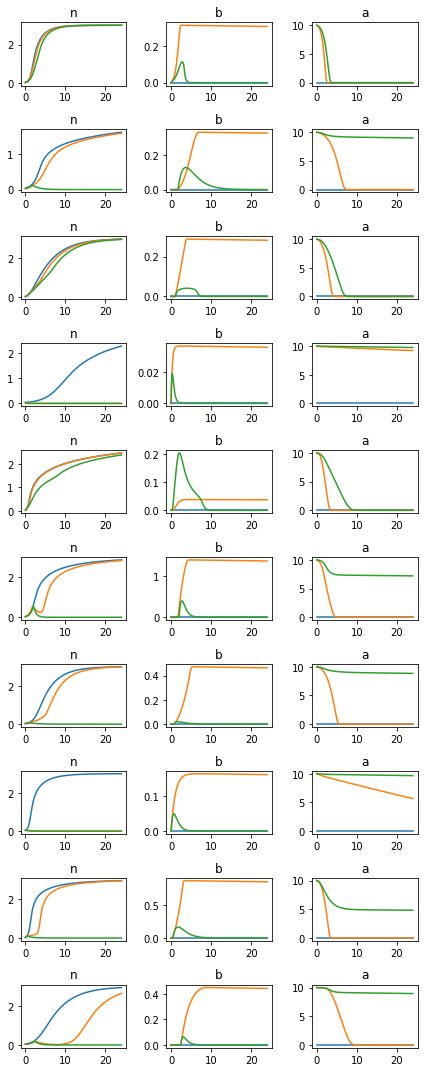

In [8]:
from tqdm.notebook import trange

#n_baseline = 0.035  #assuming a baseline value to be added to cell density to represent the baseline reading in a platereader.
n0_mean = 0.03618  #from exp   
n0_std = 0.004677 #from exp

# The conditions to be simulated
conditions = [(0, 0), (10, 0), (10, 10)]
t_min = 0
t_max = 24
time_points = 145

num_simulations = 10000

# Initialize the array to store the time courses
time_courses = np.empty((num_simulations, len(conditions), 3, time_points))
parameters = np.empty((num_simulations, 10))
parameter_scale = np.array([3, 0.6,  6,  0.8, 10, 10, 6, 1.0, 5, 1.0])
for i in trange(num_simulations):
    #
    # Here I assume each parameter follows a somewhat flat truncated Gaussian distribution, 
    # with std = 2 * mean, except for betamin and c, which are even wider (std = 10 * mean)
    # The idea is to sample extensively over the parametric space, which hopefully will cover the parameter combinations to fit experimental data.
    # 
    alpha = get_truncated_normal(mean=1.4, sd=4, low=0.2, upp=3).rvs()
    Ks = get_truncated_normal(mean=0.1, sd=0.5, low=0.0, upp=0.6).rvs()
    theta = get_truncated_normal(mean=3, sd=5, low=0.5, upp=6).rvs()
    Ln = get_truncated_normal(mean=0.2, sd=0.4, low=0, upp=0.8).rvs()
    kappab = get_truncated_normal(mean=3, sd=10, low=0, upp=10).rvs()
    phimax = get_truncated_normal(mean=3, sd=10, low=0, upp=10).rvs()
    gamma = get_truncated_normal(mean=2, sd=3.2, low=0, upp=6).rvs()
    betamin = get_truncated_normal(mean=0.5, sd=100, low=0, upp=1).rvs()
    db = get_truncated_normal(mean=1.5, sd=3, low=0.01, upp=5).rvs()
    c = get_truncated_normal(mean=0.5, sd=100, low=0, upp=1).rvs()

    parameters[i] = [alpha, Ks, theta, Ln, kappab, phimax, gamma, betamin, db, c]
    p = parameters[i]

     # Simulate under different conditions
    for j, (a0, inh) in enumerate(conditions):
        n0 = get_truncated_normal(mean=n0_mean, sd=n0_std, low=0.02, upp=0.05).rvs()
        time_courses[i, j] = simulate(p, n0, a0, inh)

time_courses[:,:,0,:] = time_courses[:,:,0,:]
# Save the time courses
#np.savez('../simulated_v4/round1/curves10k.npz', time_courses)
#np.save('../simulated_v4/round1/para10k.npy', parameters)

# Plot the first 20 strains
fig, axs = plt.subplots(10, 3, figsize=(6, 15))


time = np.linspace(t_min, t_max, time_points)
variables = ['n', 'b', 'a']

for i in range(10):
    for k, var in enumerate(variables):
        ax = axs[i, k]
        ax.set_title(f'{var}')
        for j in range(len(conditions)):
            a0, inh = conditions[j]
            ax.plot(time, time_courses[i, j, k], label=f'{a0},{inh}')
        #ax.legend()

plt.tight_layout()
plt.show()

In [9]:
# Save parameters
np.save('./data/my_curves10k.npy', time_courses)
np.save('./data/my_para10k.npy', parameters)